# Data Analysis

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from data import get_data

In [3]:
X, y = get_data()
X['total'] = y
X.head()

,month,day_of_month,day_of_week,precip_intensity_max,precip_intensity_avg,precip_type,wind_speed_max,wind_speed_avg,gust_max,gust_avg,temp_min,temp_max,temp_avg,temp_day,temp_night,humidity,total
0,-1.32775,-1.333804,0.715221,-0.345257,-0.445241,1,-0.917233,-0.923324,-0.326947,-1.079256,-1.158556,-1.699174,-1.437195,-1.585372,-1.824568,0.496020,45
1,-1.32775,0.901803,0.715221,-0.638010,-0.594762,0,1.391766,1.399861,0.031456,0.047347,-2.580424,-2.229699,-2.497102,-2.097780,-2.891915,-2.242012,34
2,-1.00909,-1.333804,0.715221,-0.218821,-0.484588,2,-0.189796,-0.173513,-0.142027,-0.673771,-2.290813,-2.044016,-2.224072,-1.918437,-1.648026,0.853155,45
3,-1.32775,-1.120889,-1.789869,-0.638010,-0.594762,0,0.901360,0.916376,-0.378420,-0.201474,-1.891827,-2.268015,-2.095227,-2.134787,-2.221381,-0.575384,47
4,-1.00909,-1.120889,-1.789869,-0.638010,-0.594762,0,-0.312397,-0.304627,-1.131447,-0.899552,-1.361900,-1.181913,-1.331358,-1.085774,-1.092487,0.972200,42


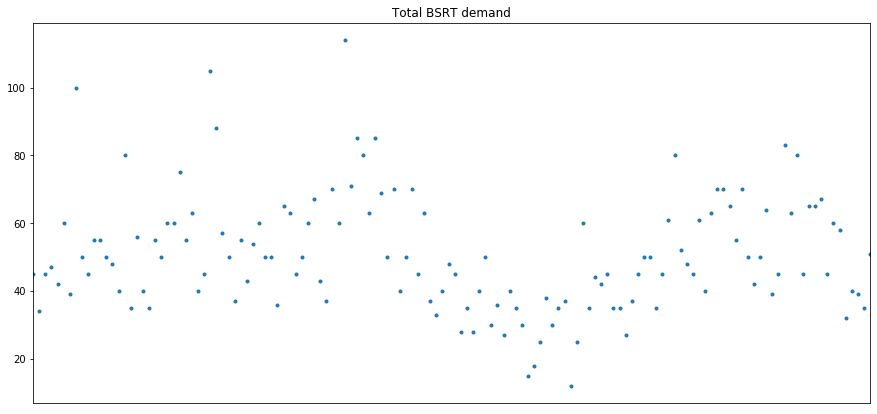

In [15]:
y.plot(style = '.', figsize = (15, 7), title = 'Total BSRT demand', xticks = [])

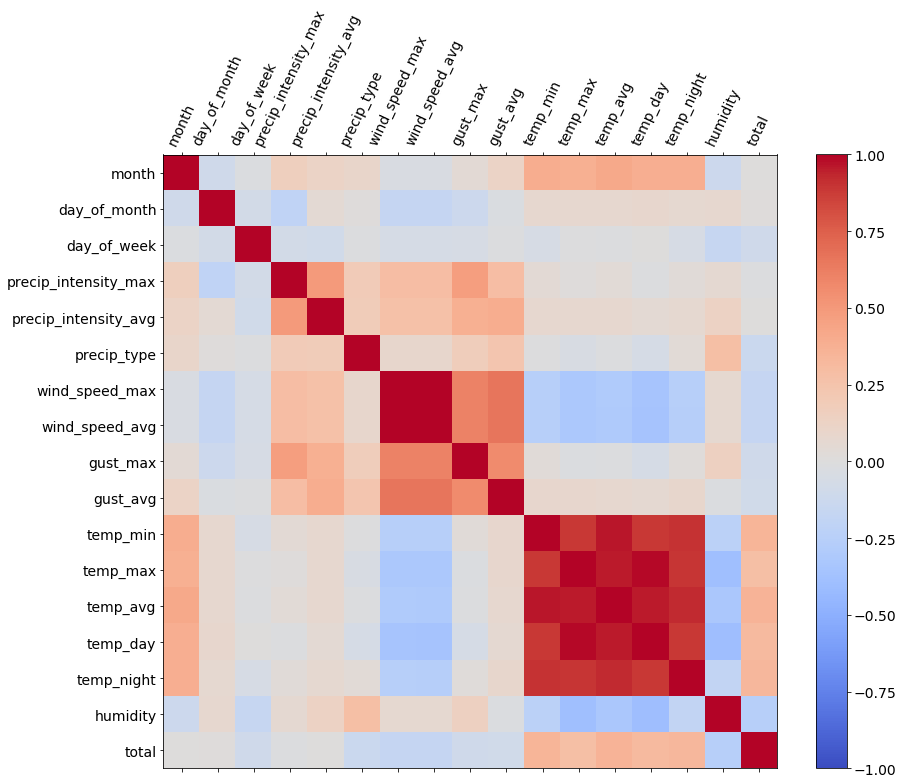

In [11]:
f = plt.figure(figsize = (14, 11))
plt.matshow(X.corr(), fignum = f.number, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.xticks(range(X.shape[1]), X.columns, fontsize=14, rotation=65)
plt.yticks(range(X.shape[1]), X.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)